# Model analysis

In [ ]:
import project_path  # Always import this first

In [2]:
from datetime import datetime
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

from utils.concrete import ConcreteSelect, decoder_1l, decoder_2l, decoder_3l
from utils.dataset import MRISelectorSubjDataset
from utils.env import DATA_PATH
from utils.logger import logger

In [3]:
sns.set_theme(context="notebook", style="ticks", rc={'figure.figsize':(11.7/2, 8.27/2)})

In [4]:
ROOT_PATH = Path().cwd().parent
logger.debug(ROOT_PATH)

2021-07-02 15:46:08,665 - geometric-dl - DEBUG - /home/maarten/Workspace/School/uu/thesis/geometric-dl-dmri (<ipython-input-4-6bfbdaf6256e>:2)


In [5]:
logger.info("torch version %s", torch.__version__)

2021-07-02 15:46:08,671 - geometric-dl - INFO - torch version 1.9.0 (<ipython-input-5-3c2fef3d866b>:1)


In [6]:
# use gpu if available, else cpu
has_cuda = torch.cuda.is_available()

logger.info("Is the GPU available? %s", has_cuda)
logger.info("Current device: %s", torch.cuda.current_device())
logger.info("Device count: %s", torch.cuda.device_count())

device = torch.device("cuda" if has_cuda else "cpu")
if has_cuda:
    torch.cuda.set_device(0)
    logger.info("Using device: %s", torch.cuda.get_device_properties(device))
else:
    logger.warning("No GPU dectected! Training will be extremly slow")

2021-07-02 15:46:08,709 - geometric-dl - INFO - Is the GPU available? True (<ipython-input-6-0077c854e8eb>:4)
2021-07-02 15:46:08,711 - geometric-dl - INFO - Current device: 0 (<ipython-input-6-0077c854e8eb>:5)
2021-07-02 15:46:08,712 - geometric-dl - INFO - Device count: 1 (<ipython-input-6-0077c854e8eb>:6)
2021-07-02 15:46:08,712 - geometric-dl - INFO - Using device: _CudaDeviceProperties(name='NVIDIA GeForce GTX 1080', major=6, minor=1, total_memory=8118MB, multi_processor_count=20) (<ipython-input-6-0077c854e8eb>:11)


## Loading the models

First we need to cleanup the filename string. For this we define some helper functions. The string does not really have a nice structure so the cleanup functions are a bit messy.

In [7]:
def extract_features(feature_str):
    """Create a Dict with all the features from the model, extracted from its file name"""
    strdate = feature_str[:14]
    features_dict = to_dict(
        [split_str(substr) for substr in feature_str[15:].split("=")]
    )
    features_dict["datetime"] = datetime.strptime(strdate, "%Y%m%d%H%M%S")

    return features_dict


def split_str(s):
    if s.startswith("decoder"):
        # name of the decoder function string contains a '_' character so it needs special treatment
        split = s.split("_", 2)
        return ["_".join(split[:2]), split[-1]]
    return s.split("_", 1)


def to_dict(fs):
    return dict([fs[i][-1], l[0]] for i, l in enumerate(fs[1:]))

Create lookup Dict to map decoder name to decoder function

In [8]:
decoder_dict = dict(
    [decoder.__name__, decoder] for decoder in [decoder_1l, decoder_2l, decoder_3l]
)

Load the models and store them in a pandas dataframe

In [9]:
models_path = Path(ROOT_PATH, "runs", "models")

frames = []
for model_path in models_path.glob("*.pt"):
    stem = model_path.stem # get the file name without the suffix
    
    logger.debug('found: %s', stem)

    features_dict = extract_features(stem)

    features_path = model_path.name.replace('_params.pt', '.txt')
    features_path = model_path.with_name(features_path)

    features_dict["params_path"] = model_path
    features_dict["features_path"] = features_path

    # Convert types
    features_dict["lr"] = float(features_dict["lr"])
    features_dict["batch_size"] = int(features_dict["batch_size"])
    features_dict["num_epochs"] = int(features_dict["num_epochs"])
    features_dict["n_features"] = int(features_dict["n_features"])
    features_dict["test"] = int(features_dict["test"])

    df_part = pd.DataFrame(features_dict, index=[features_dict["datetime"]])
    frames.append(df_part)

df = pd.concat(frames)
df

2021-07-02 15:46:08,741 - geometric-dl - DEBUG - found: 20210701001525_lr=0.001_batch_size=256_num_epochs=2000_n_features=336_decoder=decoder_2l_test=15_params (<ipython-input-9-c37667bdfe90>:7)
2021-07-02 15:46:08,748 - geometric-dl - DEBUG - found: 20210629004725_lr=0.001_batch_size=256_num_epochs=2000_n_features=42_decoder=decoder_1l_test=15_params (<ipython-input-9-c37667bdfe90>:7)
2021-07-02 15:46:08,751 - geometric-dl - DEBUG - found: 20210701053027_lr=0.001_batch_size=256_num_epochs=2000_n_features=336_decoder=decoder_3l_test=15_params (<ipython-input-9-c37667bdfe90>:7)
2021-07-02 15:46:08,754 - geometric-dl - DEBUG - found: 20210630140954_lr=0.001_batch_size=256_num_epochs=2000_n_features=168_decoder=decoder_3l_test=15_params (<ipython-input-9-c37667bdfe90>:7)
2021-07-02 15:46:08,756 - geometric-dl - DEBUG - found: 20210628193111_lr=0.001_batch_size=256_num_epochs=2000_n_features=21_decoder=decoder_3l_test=15_params (<ipython-input-9-c37667bdfe90>:7)
2021-07-02 15:46:08,758 - g

,lr,batch_size,num_epochs,n_features,decoder,test,datetime,params_path,features_path
2021-07-01 00:15:25,0.001,256,2000,336,decoder_2l,15,2021-07-01 00:15:25,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...
2021-06-29 00:47:25,0.001,256,2000,42,decoder_1l,15,2021-06-29 00:47:25,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...
2021-07-01 05:30:27,0.001,256,2000,336,decoder_3l,15,2021-07-01 05:30:27,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...
2021-06-30 14:09:54,0.001,256,2000,168,decoder_3l,15,2021-06-30 14:09:54,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...
2021-06-28 19:31:11,0.001,256,2000,21,decoder_3l,15,2021-06-28 19:31:11,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...
2021-06-29 09:33:59,0.001,256,2000,42,decoder_3l,15,2021-06-29 09:33:59,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...
2021-06-29 04:45:53,0.001,256,2000,42,decoder_2l,15,2021-06-29 04:45:53,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...
2021-06-30 04:53:13,0.001,256,2000,168,decoder_1l,15,2021-06-30 04:53:13,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...
2021-06-28 14:48:27,0.001,256,2000,21,decoder_2l,15,2021-06-28 14:48:27,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...
2021-06-29 23:41:58,0.001,256,2000,84,decoder_3l,15,2021-06-29 23:41:58,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15 entries, 2021-07-01 00:15:25 to 2021-06-30 19:21:00
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   lr             15 non-null     float64       
 1   batch_size     15 non-null     int64         
 2   num_epochs     15 non-null     int64         
 3   n_features     15 non-null     int64         
 4   decoder        15 non-null     object        
 5   test           15 non-null     int64         
 6   datetime       15 non-null     datetime64[ns]
 7   params_path    15 non-null     object        
 8   features_path  15 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 1.2+ KB


## Model evalutation

In [11]:
IMAGES_PATH = Path(ROOT_PATH, 'images')
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

In [12]:
test_set = MRISelectorSubjDataset(
    Path(ROOT_PATH, "data"), "data_.hdf5", "header_.csv", np.array([15])
)
test_gen = DataLoader(
    test_set,
    batch_size=256,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    drop_last=True,
)

### Reconstruction loss (MSE) for each model

In [13]:
mse_loss = torch.nn.MSELoss().to(device)

def calc_loss(row):
    model_path = row["params_path"]
    model = ConcreteSelect(
        output_dim=int(row["n_features"]),
        input_shape=1344,
        decoder=decoder_dict[row["decoder"]],
        device=device
    ).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    with torch.no_grad():
        target = torch.from_numpy(test_set[10]).to(device)
        pred, _ = model(target)
        loss = mse_loss(pred, target).to('cpu')
    
    logger.info("decoder: %s - latent space: %s - loss: %s", row["decoder"], row["n_features"], loss.item())
    
    return loss.item()
    
df['loss'] = df.apply(calc_loss, axis = 1)

2021-07-02 15:46:11,555 - geometric-dl - INFO - decoder: decoder_2l - latent space: 336 - loss: 0.002026401227340102 (<ipython-input-13-136c5ed4bc67>:18)
2021-07-02 15:46:11,558 - geometric-dl - INFO - decoder: decoder_1l - latent space: 42 - loss: 100.25167846679688 (<ipython-input-13-136c5ed4bc67>:18)
2021-07-02 15:46:11,562 - geometric-dl - INFO - decoder: decoder_3l - latent space: 336 - loss: 0.0018655299209058285 (<ipython-input-13-136c5ed4bc67>:18)
2021-07-02 15:46:11,565 - geometric-dl - INFO - decoder: decoder_3l - latent space: 168 - loss: inf (<ipython-input-13-136c5ed4bc67>:18)
2021-07-02 15:46:11,568 - geometric-dl - INFO - decoder: decoder_3l - latent space: 21 - loss: 2.192021369934082 (<ipython-input-13-136c5ed4bc67>:18)
2021-07-02 15:46:11,570 - geometric-dl - INFO - decoder: decoder_3l - latent space: 42 - loss: 1.8148150444030762 (<ipython-input-13-136c5ed4bc67>:18)
2021-07-02 15:46:11,573 - geometric-dl - INFO - decoder: decoder_2l - latent space: 42 - loss: 11.9801

In [14]:
df.replace(np.inf, np.nan, inplace=True)
df.sort_index()

,lr,batch_size,num_epochs,n_features,decoder,test,datetime,params_path,features_path,loss
2021-06-28 10:44:35,0.001,256,2000,21,decoder_1l,15,2021-06-28 10:44:35,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,158.008682
2021-06-28 14:48:27,0.001,256,2000,21,decoder_2l,15,2021-06-28 14:48:27,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,10.391368
2021-06-28 19:31:11,0.001,256,2000,21,decoder_3l,15,2021-06-28 19:31:11,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,2.192021
2021-06-29 00:47:25,0.001,256,2000,42,decoder_1l,15,2021-06-29 00:47:25,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,100.251678
2021-06-29 04:45:53,0.001,256,2000,42,decoder_2l,15,2021-06-29 04:45:53,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,11.980187
2021-06-29 09:33:59,0.001,256,2000,42,decoder_3l,15,2021-06-29 09:33:59,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,1.814815
2021-06-29 14:51:26,0.001,256,2000,84,decoder_1l,15,2021-06-29 14:51:26,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,109.211105
2021-06-29 18:54:22,0.001,256,2000,84,decoder_2l,15,2021-06-29 18:54:22,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,12.370683
2021-06-29 23:41:58,0.001,256,2000,84,decoder_3l,15,2021-06-29 23:41:58,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,0.579465
2021-06-30 04:53:13,0.001,256,2000,168,decoder_1l,15,2021-06-30 04:53:13,/home/maarten/Workspace/School/uu/thesis/geome...,/home/maarten/Workspace/School/uu/thesis/geome...,NaN


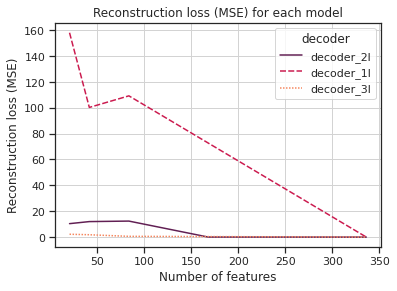

In [15]:
plot = sns.lineplot(x="n_features", y="loss", hue="decoder", style="decoder", data=df, palette='rocket')
# plot.set(yscale='log')
plot.set(xlabel="Number of features", ylabel="Reconstruction loss (MSE)", title="Reconstruction loss (MSE) for each model")
plt.grid(True,which="both",ls="-",c='lightgray')

image_path = Path(IMAGES_PATH, 'reconstruction_loss_(MSE).pdf')
plt.savefig(image_path);

### Plot feature occurence count

Some features occure multiple times in a single model. Lets plot the top 20 most occuring features.

In [16]:
counts_dfs = []
for _, row in df.iterrows():
    features = np.loadtxt(row["features_path"], dtype=np.int64)
    counts = np.bincount(features)
    counts_df = pd.DataFrame(counts, columns=['count'])
    counts_dfs.append(counts_df)
# sum all the bin counts    
df_counts = pd.concat(counts_dfs).groupby(level=0).sum().reset_index()
df_counts

,index,count
0,0,0
1,1,0
2,2,0
3,3,0
4,4,13
...,...,...
1334,1334,0
1335,1335,0
1336,1336,2
1337,1337,1


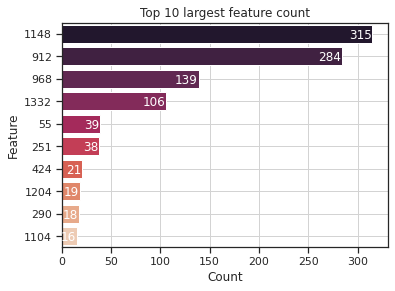

In [19]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    """Code from https://stackoverflow.com/a/56780852/6131485"""
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() - float(space)
                _y = p.get_y() + p.get_height() - .2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="right", c="white")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
df_counts_top_20 = df_counts.sort_values(by='count', ascending=False)[:10]

plot = sns.barplot(orient="h", x="count", y="index", data=df_counts_top_20, order=df_counts_top_20["index"].values, palette="rocket")
plot.set(xlabel="Count", ylabel="Feature", title="Top 10 largest feature count")
show_values_on_bars(plot, "h", 1.0)
plt.grid(True,which="both",ls="-",c='lightgray')

image_path = Path(IMAGES_PATH, 'feature_count.pdf')
plt.savefig(image_path);